My goal is to find data on hydrologic basins and river connections between them. I am working with the HydroATLAS dataset, which is big. Also, here is its [technical documentation](https://data.hydrosheds.org/file/technical-documentation/HydroATLAS_TechDoc_v10_1.pdf).

In [1]:
# libraries
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np

Much exploring happened in other notebooks. The size of the dataset quickly filled the memory; what is here is just what works.

First, I want to import just the data within my region of interest: LA County. I will use the bounding box feature...

In [2]:
# Set the bounding box
bbox = (
    -118.9441,32.8065,-117.6447,34.8227
) # Source: https://observablehq.com/@rdmurphy/u-s-county-bounding-boxes-by-state

In [3]:
# Read the data... just the basins all or partially within the box!
b=gp.read_file("data/BasinATLAS_Data_v10.gdb.zip", driver='FileGDB', layer='BasinATLAS_v10_lev12',bbox=bbox)

First, a quick plot to make sure there are data and that they are in LA!

<AxesSubplot: >

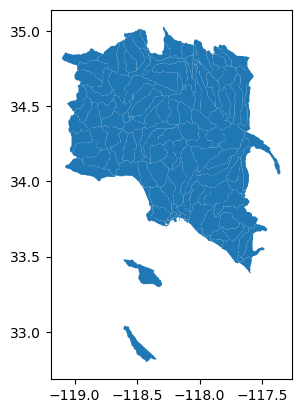

In [4]:
b.plot()

That looks good! I don't really need those islands. Let me see if I can figure out what they are called so I can remove them...

In [5]:
#source: https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html
b.explore(
     column="HYBAS_ID",
     tooltip="HYBAS_ID",
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="Set1", # use "Set1" matplotlib colormap
     style_kwds=dict(color="black") # use black outline
    )

Okay, the islands have IDs: 7120055730 and 7120055740. Can I just filter...

In [6]:
b = b[b['HYBAS_ID']!=7120055730]
b = b[b['HYBAS_ID']!=7120055740]

<AxesSubplot: >

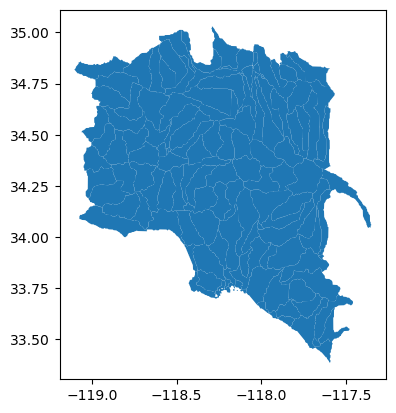

In [7]:
b.plot()

Good. So, what does the data look like?

In [8]:
b.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 133 entries, 0 to 134
Data columns (total 297 columns):
 #    Column        Non-Null Count  Dtype   
---   ------        --------------  -----   
 0    HYBAS_ID      133 non-null    float64 
 1    NEXT_DOWN     133 non-null    float64 
 2    NEXT_SINK     133 non-null    float64 
 3    MAIN_BAS      133 non-null    float64 
 4    DIST_SINK     133 non-null    float64 
 5    DIST_MAIN     133 non-null    float64 
 6    SUB_AREA      133 non-null    float64 
 7    UP_AREA       133 non-null    float64 
 8    PFAF_ID       133 non-null    float64 
 9    ENDO          133 non-null    int64   
 10   COAST         133 non-null    int64   
 11   ORDER_        133 non-null    int64   
 12   SORT          133 non-null    float64 
 13   dis_m3_pyr    133 non-null    float64 
 14   dis_m3_pmn    133 non-null    float64 
 15   dis_m3_pmx    133 non-null    float64 
 16   run_mm_syr    133 non-null    int64   
 17   inu_pc_smn    133 non-nul

Lot's of info! How many "main basins" are present?

In [9]:
np.unique(b['MAIN_BAS'])

array([7.12001252e+09, 7.12001253e+09, 7.12001254e+09, 7.12001255e+09,
       7.12001256e+09, 7.12001257e+09, 7.12001258e+09, 7.12001259e+09,
       7.12001260e+09, 7.12001261e+09, 7.12001262e+09, 7.12001263e+09,
       7.12001264e+09, 7.12001265e+09, 7.12001266e+09, 7.12001267e+09,
       7.12001268e+09, 7.12001269e+09, 7.12001270e+09, 7.12001271e+09,
       7.12001272e+09, 7.12001273e+09, 7.12001274e+09, 7.12001275e+09,
       7.12001277e+09, 7.12001280e+09, 7.12001355e+09, 7.12007433e+09,
       7.12007439e+09, 7.12007734e+09])

Huh. That's more than I expected. Maybe... maybe there are a bunch of small ones along the coast. Okay, mapping time!

<AxesSubplot: >

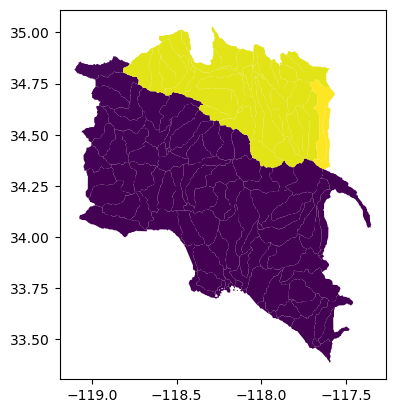

In [10]:
b.plot(column=b['MAIN_BAS'])

Oh! That's... why are there only three? Three makes sense -- the south directly to the ocean, the north to Tulere, and the NE to the desert, but... oooo. The colors are too similar to see.

In [11]:
b['MAIN']=b['MAIN_BAS']-7120000000

In [12]:
np.unique(b['MAIN'])

array([12520., 12530., 12540., 12550., 12560., 12570., 12580., 12590.,
       12600., 12610., 12620., 12630., 12640., 12650., 12660., 12670.,
       12680., 12690., 12700., 12710., 12720., 12730., 12740., 12750.,
       12770., 12800., 13550., 74330., 74390., 77340.])

<AxesSubplot: >

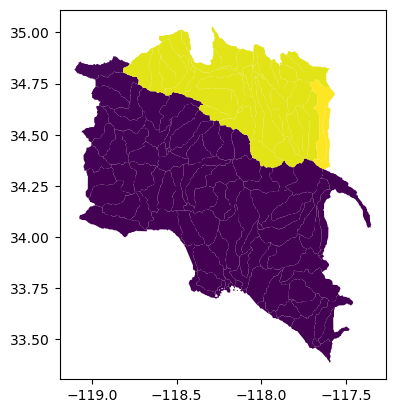

In [13]:
b.plot(column=b['MAIN'])

Hmm. Perhaps it already does that... can I edit them more substantially?

In [15]:
b['MAIN']=(b['MAIN']>14000)*(b['MAIN']-63000)+(b['MAIN']<14000)*(b['MAIN'])
np.unique(b['MAIN'])

array([11330., 11390., 12520., 12530., 12540., 12550., 12560., 12570.,
       12580., 12590., 12600., 12610., 12620., 12630., 12640., 12650.,
       12660., 12670., 12680., 12690., 12700., 12710., 12720., 12730.,
       12740., 12750., 12770., 12800., 13550., 14340.])

Did that work?

<AxesSubplot: >

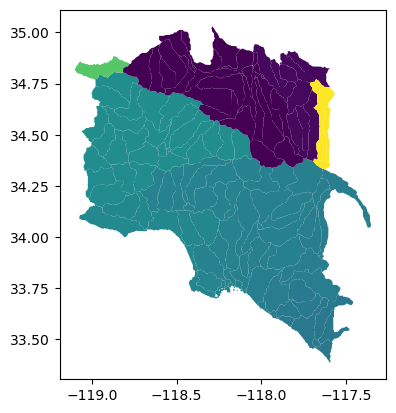

In [16]:
b.plot(column=b['MAIN'])

Yes! So how are these basins connected? This is going to take some experimentation... first, let's render each basin as a point...

/tmp/ipykernel_7310/2905836660.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  b.centroid.plot()


<AxesSubplot: >

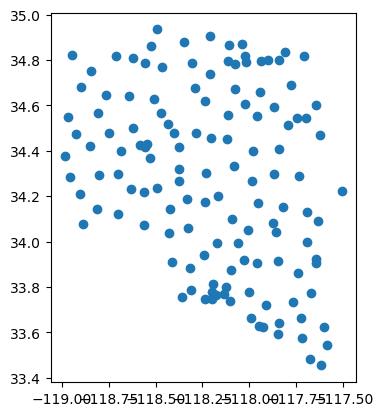

In [17]:
b.centroid.plot()

Okay, now I want to make line segments connecting connected basins. I'll need coordinates...

In [18]:
b['x']=b.centroid.x
b['y']=b.centroid.y

/tmp/ipykernel_7310/3701430586.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  b['x']=b.centroid.x
/tmp/ipykernel_7310/3701430586.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  b['y']=b.centroid.y


Now I need to be able to make line segments...

In [19]:
x0 = b['x'].iloc[0]
y0 = b['y'].iloc[0]
x1 = b['x'].iloc[1]
y1 = b['y'].iloc[1]
lines=[[(x0, y0), (x1, y1)]]

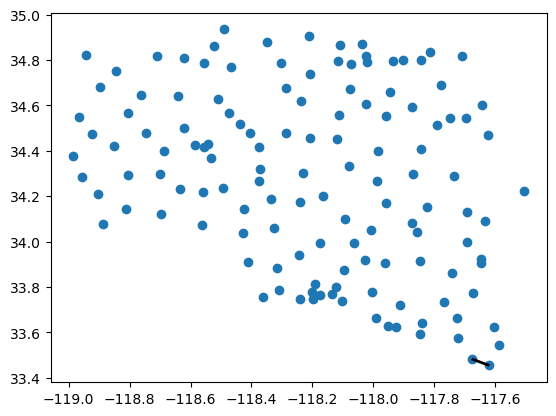

In [20]:
# Source: https://stackoverflow.com/questions/12864294/adding-an-arbitrary-line-to-a-matplotlib-plot-in-ipython-notebook
plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()

Okay! This has promise! I should probably start with a point not on the coast. Can I get lucky?

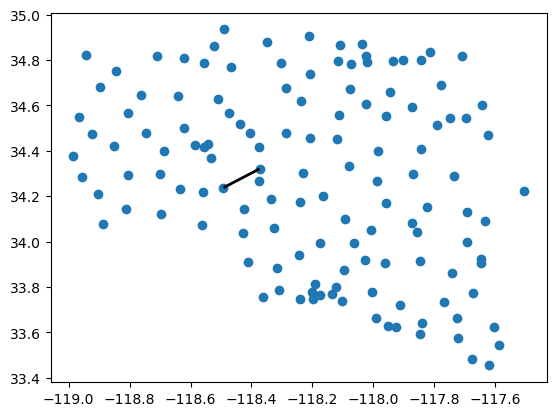

In [21]:
# This code is the same as above but for entries 50 and 51 instead of 0 and 1
x0 = b['x'].iloc[50]
y0 = b['y'].iloc[50]
x1 = b['x'].iloc[51]
y1 = b['y'].iloc[51]
lines=[[(x0, y0), (x1, y1)]]
plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()

Yes! Now.... I want my second point to not just be the next point in the data, but to have the coordiantes of the next basin...

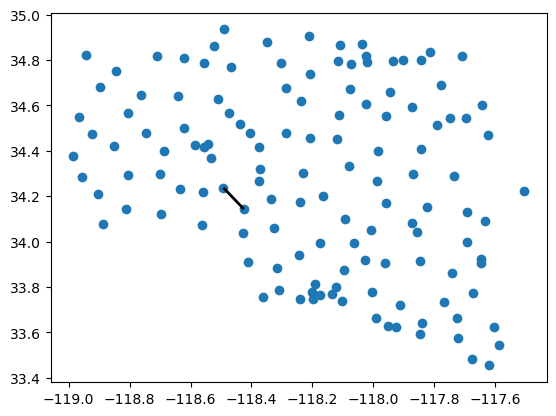

In [22]:
x0 = b['x'].iloc[50]
y0 = b['y'].iloc[50]
x1=b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[50]]['x']
y1=b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[50]]['y']
# This part is the same...
lines=[[(x0, y0), (x1, y1)]]
plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()

Before I can get to looping, I need to deal with coastal points, because they don't have a downstream basin, so no second point, so no line segment.

In [23]:
# First, let's do this looking-up-next-point-thing with a function...
def get_next(n):
    next_basin = b['NEXT_DOWN'].iloc[n]
    if next_basin == 0:
        return[-118.8,33.6]
    else:
        xi = (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['x'])
        yi = (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['y'])
        return [xi,yi]

In [24]:
# Does it work?
get_next(50)

[49   -118.424754
 Name: x, dtype: float64,
 49    34.142669
 Name: y, dtype: float64]

In [25]:
# How about now?
get_next(0)

[-118.8, 33.6]

Does this work now? Should be a line out to sea...

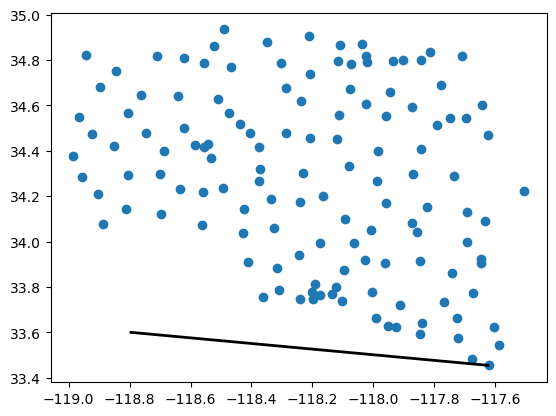

In [26]:
n=0
x0 = b['x'].iloc[n]
y0 = b['y'].iloc[n]
x1=get_next(n)[0]
y1=get_next(n)[1]
# This part is the same...
lines=[[(x0, y0), (x1, y1)]]
plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()

Yes! Now... looping time... oh! Wait. Well... Okay.... my points that drain out of this basin will also go to the ocean. Let's solve that later...

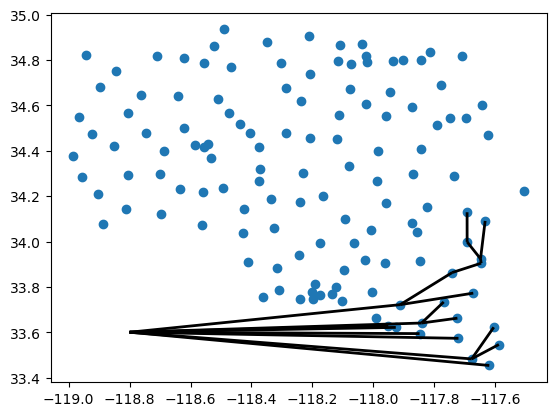

In [27]:
lines = []
# b.shape[0]-110
for n in list(range(0,19)):
    x0 = b['x'].iloc[n]
    y0 = b['y'].iloc[n]
    x1 = get_next(n)[0]
    y1 = get_next(n)[1]
    lines.append([(x0, y0), (x1, y1)])

plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()

Up to here, it works fine. Then, there is probably the first point that goes somewhere else...

In [28]:
# What is returned?
print(get_next(19))
# Why?
print(b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[19]]['y'])
print(b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[19]]['y'])

[Series([], Name: x, dtype: float64), Series([], Name: y, dtype: float64)]
Series([], Name: y, dtype: float64)
Series([], Name: y, dtype: float64)


Yes, this is the flowing-out-of-the-dataset problem, I think. The basin where it flows is not in the data, so there is no point for the line. So I need to modify the `get_next` function...

In [30]:
def get_next(n):
    next_basin = b['NEXT_DOWN'].iloc[n]
    if next_basin == 0:
        return [-118.8,33.6]
    else:
        xi = (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['x'])
        yi = (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['y'])
        if (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['y']).empty:
            return [-117.5,35]
        else:
             return [xi,yi]

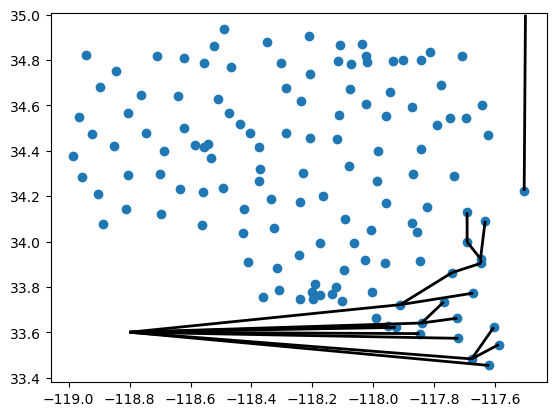

In [31]:
lines = []
for n in list(range(0,20)):
    x0 = b['x'].iloc[n]
    y0 = b['y'].iloc[n]
    x1 = get_next(n)[0]
    y1 = get_next(n)[1]
    lines.append([(x0, y0), (x1, y1)])

plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()

Oh, good! This next one should be fun:

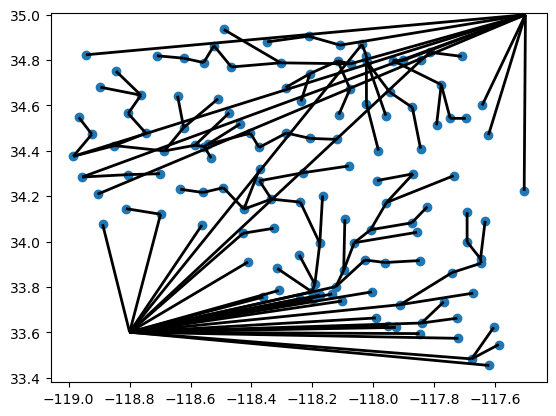

In [32]:
lines = []
for n in list(range(0,b.shape[0])):
    x0 = b['x'].iloc[n]
    y0 = b['y'].iloc[n]
    x1 = get_next(n)[0]
    y1 = get_next(n)[1]
    lines.append([(x0, y0), (x1, y1)])

plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()

Hmm, that four western areas appear to drain out to the east; that's confusing, and fixable:

In [33]:
def get_next(n):
    next_basin = b['NEXT_DOWN'].iloc[n]
    if next_basin == 0:
        return [-118.8,33.6]
    else:
        xi = (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['x'])
        yi = (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['y'])
        if (b[b['HYBAS_ID']==b['NEXT_DOWN'].iloc[n]]['y']).empty:
            if b.iloc[n]['x']<-118:
                return [-119,35]
            else:
                return [-117.5,35]
        else:
             return [xi,yi]

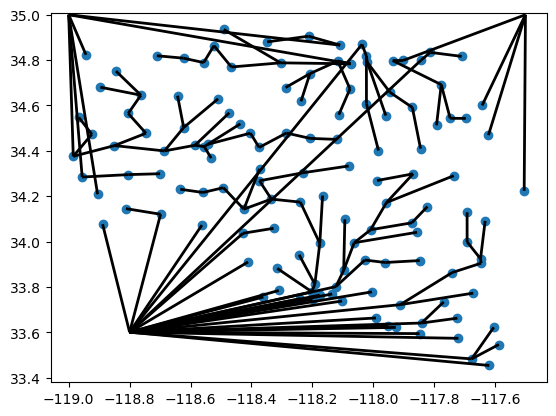

In [34]:
lines = []
for n in list(range(0,b.shape[0])):
    x0 = b['x'].iloc[n]
    y0 = b['y'].iloc[n]
    x1 = get_next(n)[0]
    y1 = get_next(n)[1]
    lines.append([(x0, y0), (x1, y1)])

plt.plot(b['x'],b['y'], "o")

from matplotlib.collections import LineCollection
lc = LineCollection(lines,color="k", lw=2)

plt.gca().add_collection(lc)
                    
plt.show()